In [1]:
!pip install -q numpy
!pip install -q pandas
!pip install -q tensorflow
!pip install -q matplotlib
!pip install -q opencv-python

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

C:\Users\Zhenia\AppData\Local\Temp\ipykernel_17944\1642364795.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Zhenia\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_images_path = './airbus-ship-detection/train_v2'
test_images_path = './airbus-ship-detection/test_v2'

In [4]:
train_data = pd.read_csv('./airbus-ship-detection/train_ship_segmentations_v2.csv')
test_data = pd.read_csv('./airbus-ship-detection/sample_submission_v2.csv')

In [5]:
train_data.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [7]:
# Show number of train and test unique images
print(f"Train unique images number: {train_data['ImageId'].nunique()}")
print(f"Test unique images number: {test_data['ImageId'].nunique()}")

Train unique images number: 192556
Test unique images number: 15606


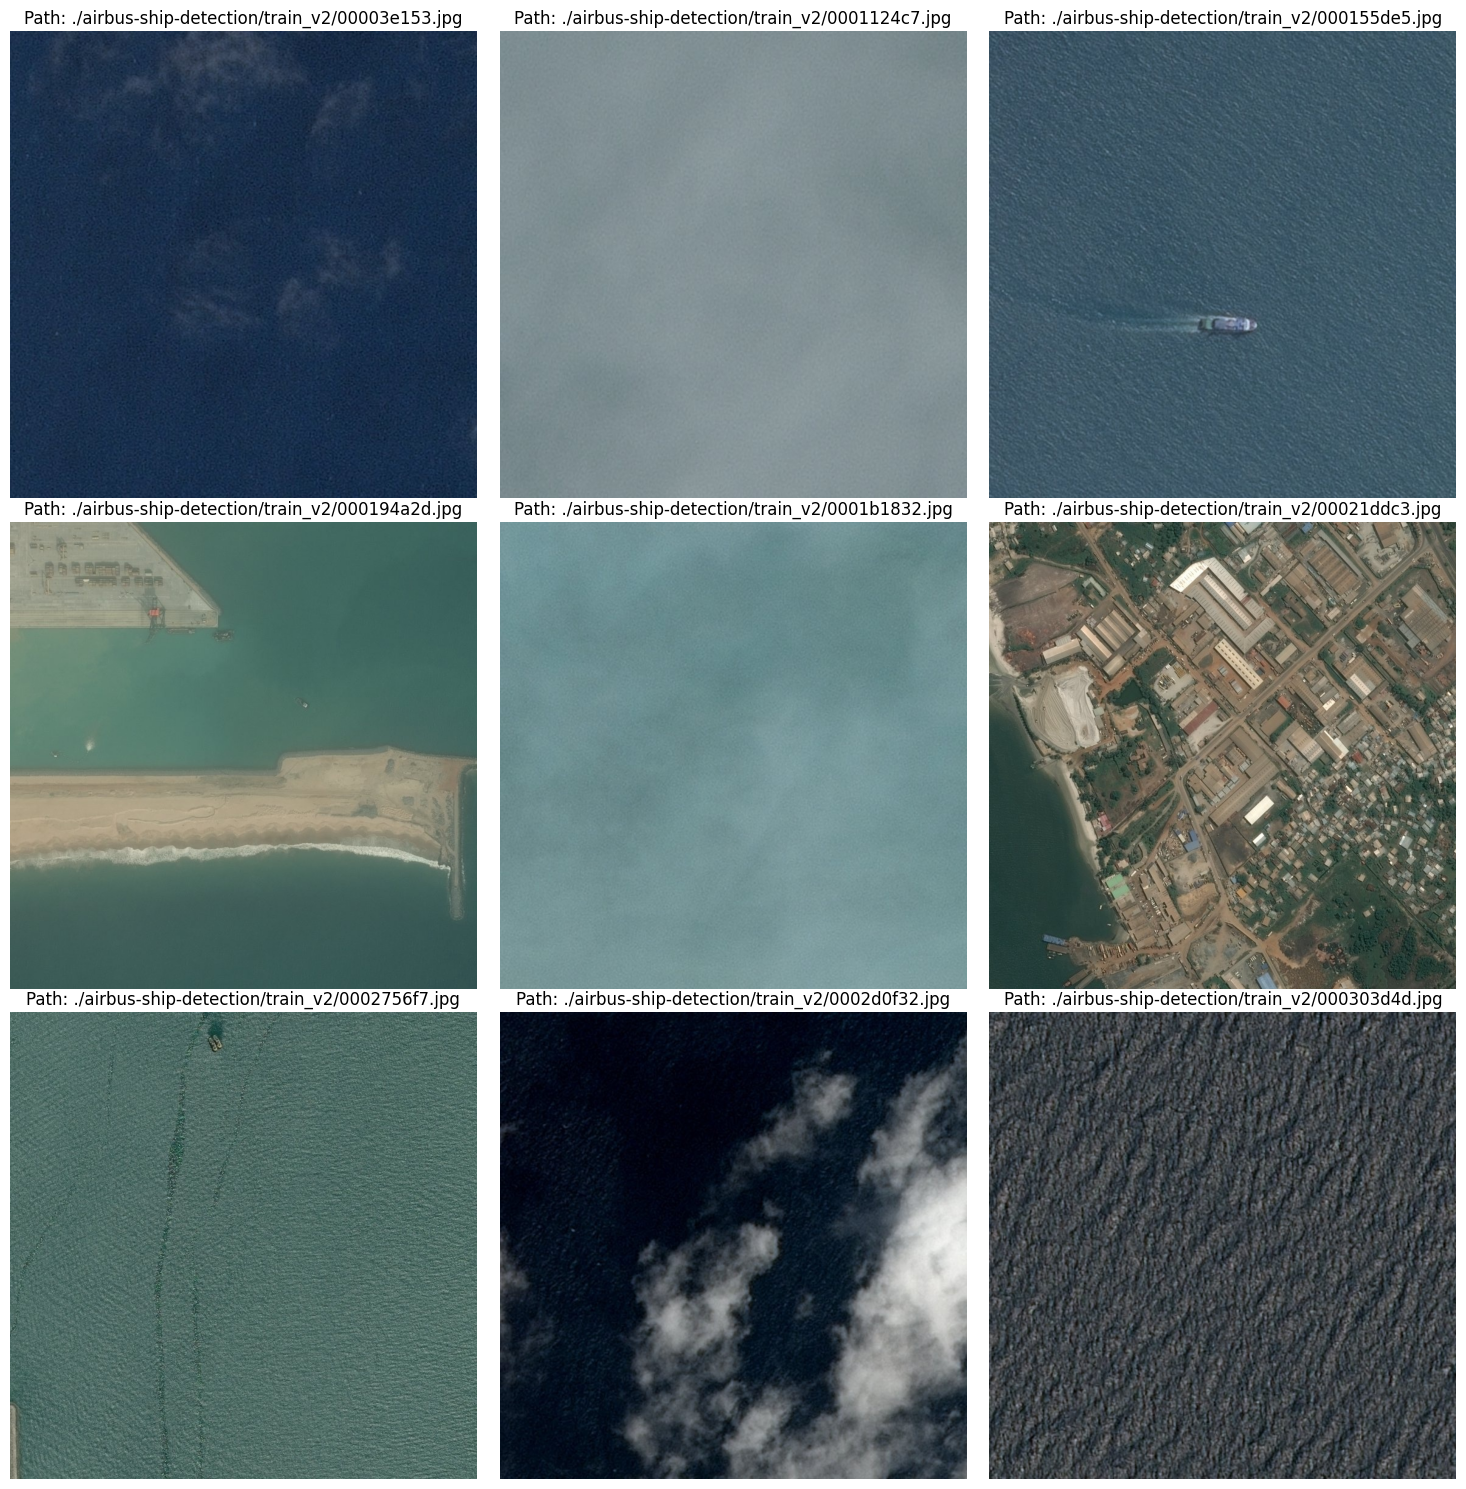

In [8]:
# Unique train images' paths
train_images_id = pd.unique(train_data['ImageId'])

# Plot first 9 images
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    image = cv2.imread(train_images_path + '/' + train_images_id[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.axis("off")
    ax.imshow(image)
    ax.set_title(f"Path: {train_images_path + '/' + train_images_id[i]}")

plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [9]:
# Number of Ship Images/No-Ship Images and Number of ships on images
train_data_ship_count = train_data.copy()
train_data_ship_count['num_of_ships'] = train_data_ship_count['EncodedPixels'].apply(lambda el: 1 if pd.notnull(el) else 0)
train_data_ship_count = train_data_ship_count.groupby('ImageId').agg({'num_of_ships': 'sum'}).reset_index()
train_data_ship_count['ships_presence'] = train_data_ship_count['num_of_ships'].apply(lambda el: 1 if el>0 else 0)
train_data_ship_count.head()

,ImageId,num_of_ships,ships_presence
0,00003e153.jpg,0,0
1,0001124c7.jpg,0,0
2,000155de5.jpg,1,1
3,000194a2d.jpg,5,1
4,0001b1832.jpg,0,0


In [10]:
# Output max and min number of ships on images
print(f"Max number of ships on image: {train_data_ship_count['num_of_ships'].max()}")
print(f"Min number of ships on image: {train_data_ship_count['num_of_ships'].min()}")

Max number of ships on image: 15
Min number of ships on image: 0


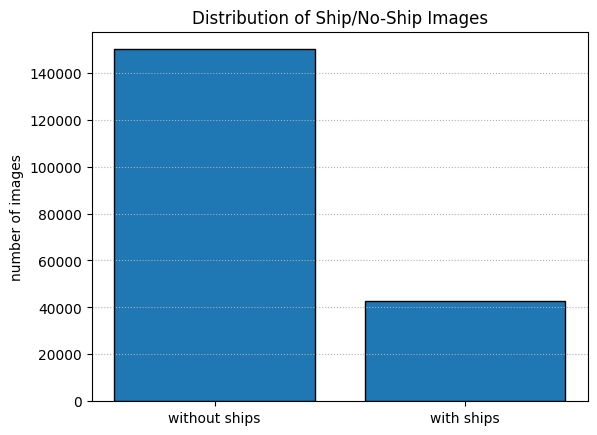

In [11]:
# Plot distribution of Ship/No-Ship Images
plt.bar(['without ships','with ships'], train_data_ship_count['ships_presence'].value_counts(), edgecolor='black')
plt.title('Distribution of Ship/No-Ship Images')
plt.ylabel('number of images')
plt.grid(linestyle=':', axis='y')
plt.show()

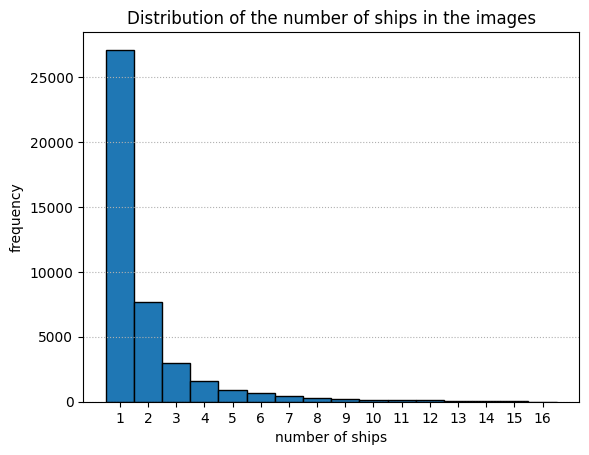

In [12]:
# Plot distribution of the number of ships in the images
train_data_with_ships = train_data_ship_count[train_data_ship_count['ships_presence'] == 1]

plt.hist(train_data_with_ships['num_of_ships'], bins=range(1, 18), edgecolor='black', align='left')
plt.xticks(range(1, 17))
plt.xlabel('number of ships')
plt.ylabel('frequency')
plt.title('Distribution of the number of ships in the images')
plt.grid(linestyle=':', axis='y')
plt.show()

In [17]:
# Helper functions
def plot_train_image(image_id: str):
    image = cv2.imread(train_images_path + '/' + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.imshow(image)


def rle_to_image(rle: str, shape: tuple) -> np.array:
    rle_split = rle.split()

    starts = np.array(rle_split[::2], dtype=int)
    lengths = np.array(rle_split[1::2], dtype=int)
    ends = starts + lengths
    
    image_mask = np.zeros(768*768, dtype=np.uint8)
    for i in range(len(starts)):
        image_mask[starts[i]:ends[i]] = 1

    return image_mask.reshape([768, 768]).T


def plot_train_image_and_masks(image_id: str):
    image = cv2.imread(train_images_path + '/' + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_masks_rle = train_data[train_data['ImageId'] == image_id]['EncodedPixels'].tolist()
    masks_number = len(image_masks_rle)
    fig, axes = plt.subplots(1, masks_number+1, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title('original image')
    for i in range(masks_number):
        axes[i+1].axis('off')
        axes[i+1].set_title(f"mask{i+1}")
        axes[i+1].imshow(rle_to_image(image_masks_rle[i], image.shape))

    plt.suptitle('Image and masks plot')
    plt.show()

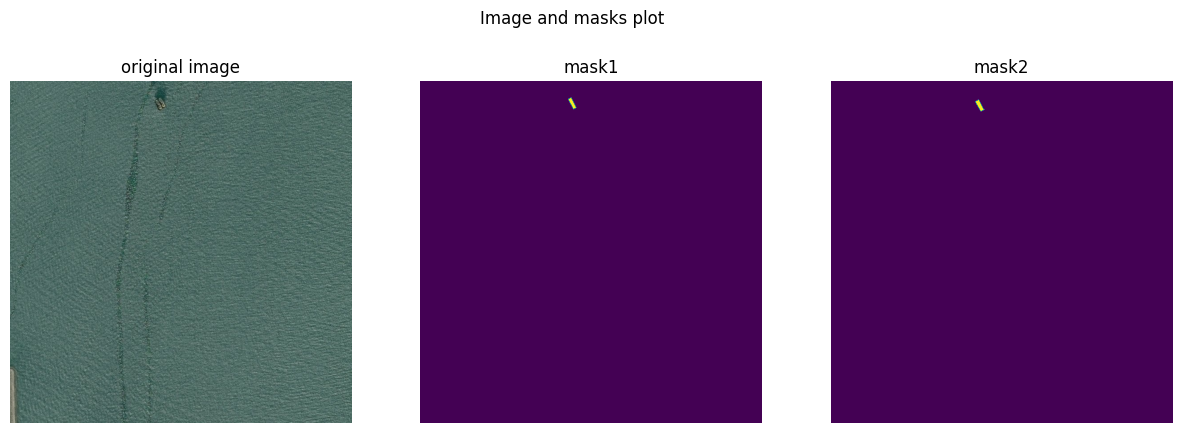

In [18]:
# Plot train image with masks
image_id = '0002756f7.jpg'
plot_train_image_and_masks(image_id)